In [1]:
import numpy as np
import cv2
import json
from paz.core import ops
from mrcnn import visualize, utils
import tensorflow as tf
import matplotlib.pyplot as plt
from pose_estimation.solver import PnPSolver
from pose_estimation.pose_evaluation import PoseError
from pose_estimation.pose import compute_poses

In [2]:
def evaluation(gt_mask, pred_mask, true_id, name):
    pnp = PnPSolver(gt_mask, true_id, name)
    gt_points3d, image2d = pnp.get_points()
    camera = pnp.compute_camera_matrix()
    _, true_R, true_T, inliers = ops.solve_PNP(gt_points3d, image2d, camera, ops.UPNP)
#     model_point = pnp.get_object_points(image2d)
#     model_point = np.diag(model_point)[..., np.newaxis].T
#     true_R, true_T, _ = pnp.solve_PnP()
    est_pnp = PnPSolver(pred_mask, true_id, name)
    points3d, image2d = est_pnp.get_points()
    _, est_R, est_T, est_inliers = ops.solve_PNP(points3d, image2d, camera, ops.UPNP)
#     est_R, est_T, _ = est_pnp.solve_PnP()
    error = PoseError(gt_points3d, est_R, est_T, true_R, true_T)
    add = error.add()
    adi = error.adi()
    rot_error = error.rotational_error()
    trans_error = error.translational_error()
    return add, adi, rot_error, trans_error

In [136]:
results_path = '/home/incendio/Desktop/inference_results/for_10k_data/bce/93_epochs/results.json'
ground_truth_path = '/home/incendio/Desktop/inference_results/for_10k_data/bce/93_epochs/ground_truth.json'
with open(results_path, 'r') as f:
    results = json.load(f)
    
with open(ground_truth_path, 'r') as f:
    ground_truth = json.load(f)

[ 9  8  6  1 19  2  4]
010_potted_meat_can
009_gelatin_box
007_tuna_fish_can
002_master_chef_can
051_large_clamp
003_cracker_box
005_tomato_soup_can


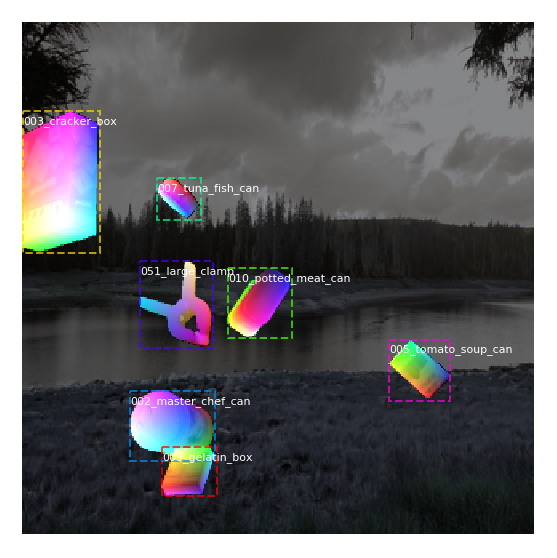

In [137]:
img_path = '/home/incendio/Desktop/inference_results/for_10k_data/bce/93_epochs/image.png'

def prepare_results(path, data, is_gt=True):
    img = cv2.imread(path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    box = np.array(data['rois'])
    class_id = np.array(data['class_ids'])
    if is_gt:
        r_mask = np.array(data['gt_r_masks'])
        g_mask = np.array(data['gt_g_masks'])
        b_mask = np.array(data['gt_b_masks'])
    else:
        r_masks = np.array(r['r_masks'])
        g_masks = np.array(r['g_masks'])
        b_masks = np.array(r['b_masks'])
    r_mask = (r_mask * 255).astype(np.uint8)
    g_mask = (g_mask * 255).astype(np.uint8)
    b_mask = (b_mask * 255).astype(np.uint8)
    masks = []
    for i in range(r_mask.shape[-1]):
        mask = np.stack([r_mask[:, :, i], g_mask[:, :, i], b_mask[:, :, i]], axis=2)
        masks.append(mask)
    masks = np.stack(masks, axis=2)
    masks = np.reshape(masks, (320, 320, 3*7))
    return image, box, class_id, masks
    
class_names = ['background', '002_master_chef_can', '003_cracker_box',
               '004_sugar_box', '005_tomato_soup_can', '006_mustard_bottle',
               '007_tuna_fish_can', '008_pudding_box', '009_gelatin_box',
               '010_potted_meat_can', '011_banana', '019_pitcher_base',
               '021_bleach_cleanser', '024_bowl',
               '025_mug', '035_power_drill',
               '036_wood_block', '037_scissors',
               '040_large_marker', '051_large_clamp',
               '052_extra_large_clamp', '061_foam_brick']
image, gt_box, gt_class_id, gt_masks = prepare_results(img_path, ground_truth)
m = np.zeros((gt_masks.shape))
good_class = [21, 9, 4]
good_ids = [4, 1, 5]
for i in good_ids:
    m_id = i*3
    m[:, :, m_id:m_id+3] = gt_masks[:, :, m_id:m_id+3]
print(gt_class_id)
for i in gt_class_id:
    print(class_names[i])
# fig = plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.show()
m = np.zeros(gt_masks.shape)
m[:, :, 12:15] = gt_masks[:, :, 12:15]
gt = visualize.display_rgb_instances(image, gt_box, gt_masks, gt_class_id, class_names, show_bbox=True, figsize=(10, 10))

010_potted_meat_can
005_tomato_soup_can
007_tuna_fish_can
003_cracker_box
002_master_chef_can
051_large_clamp
019_pitcher_base
004_sugar_box
052_extra_large_clamp
[ 9  4  6  2  1 19 11  3 20]


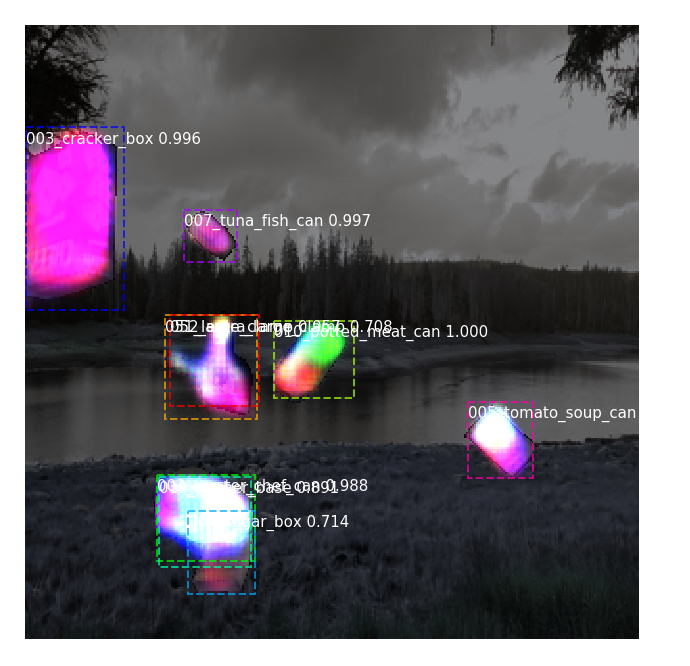

In [170]:
r = results
rois = np.array(r['rois'])
class_ids = np.array(r['class_ids'])
N = len(class_ids)

#84
r_masks = np.array(r['r_masks'])
g_masks = np.array(r['g_masks'])
b_masks = np.array(r['b_masks'])

r_masks = (r_masks * 255).astype(np.uint8)
g_masks = (g_masks * 255).astype(np.uint8)
b_masks = (b_masks * 255).astype(np.uint8)
masks = []
for i in range(r_masks.shape[-1]):
    masks.append(np.stack([r_masks[:, :, i], g_masks[:, :, i], b_masks[:, :, i]], axis=2))
masks = np.stack(masks)
for i in class_ids:
    print(class_names[i])
pred_m = np.zeros((masks.shape))
# classes = [21, 9, 4]
# g_ids = [0, 2, 6]
# for i in good_ids:
#     pred_m[i] = masks[i]
print(class_ids)
# [ 7 18 16 15 20  3 21]
pred = visualize.display_test_instances(image, rois, masks, class_ids, class_names, results['scores'], show_bbox=True, figsize=(12, 12))

In [139]:
def plot_channels(mask, channel):
    fig = plt.figure(figsize=(6, 6))
    if channel == 'r':
        plt.imshow(mask, cmap='Reds')
    if channel == 'g':
        plt.imshow(mask, cmap='Greens')
    if channel == 'b':
        plt.imshow(mask, cmap='Blues')
    plt.show()

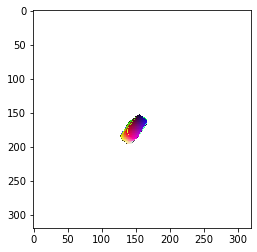

In [176]:
gt_id = 0 * 3
x = gt_masks[:, :, 0:3]
x[np.where(x==0)] = 255
plt.imshow(x)
plt.show()
# plot_channels(gt_masks[:, :, gt_id], 'r')
# plot_channels(gt_masks[:, :, gt_id+1], 'g')
# plot_channels(gt_masks[:, :, gt_id+2], 'b')

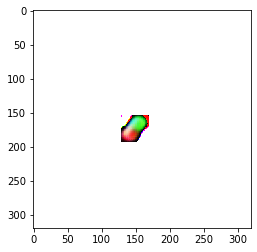

In [174]:
pr_id = 0
m = masks[pr_id]
m[np.where(m==0)] = 255
plt.imshow(m)
plt.show()
# plot_channels(m[..., 0], 'r')
# plot_channels(m[..., 1], 'g')
# plot_channels(m[..., 2], 'b')

In [159]:
from skimage.metrics import mean_squared_error
print(mean_squared_error(gt_masks[:, :, gt_id], masks[pr_id][:, :, 0]))
print(mean_squared_error(gt_masks[:, :, gt_id+1], masks[pr_id][:, :, 1]))
print(mean_squared_error(gt_masks[:, :, gt_id+2], masks[pr_id][:, :, 2]))
# print(mean_squared_error(gt_masks[:, :, gt_id:gt_id+3], masks[pr_id]))

14.09642578125
19.723046875
31.230908203125


In [131]:
from skimage.metrics import structural_similarity as ssim
print(ssim(gt_masks[:, :, gt_id], m[:, :, 0]))

0.9755388097426912


In [133]:
all_scores = {}
names = ['background', '01_master_chef_can', '02_cracker_box',
           '03_sugar_box', '04_tomato_soup_can', '05_mustard_bottle',
           '06_tuna_fish_can', '07_pudding_box', '08_gelatin_box',
           '09_potted_meat_can', '10_banana', '11_pitcher_base',
           '12_bleach_cleanser', '13_bowl',
           '14_mug', '15_power_drill',
           '16_wood_block', '17_scissors',
           '18_large_marker', '19_large_clamp',
           '20_extra_large_clamp', '21_foam_brick']
for id_, class_id in enumerate(gt_class_id):
    if class_id in class_ids:
        m_id = np.where(class_id == class_ids)
#         class_id = 20
        pred_mask = masks[m_id]
        gt_ = np.where(class_id == gt_class_id)[0][0]
        gt_mask = gt_masks[:, :, gt_*3:gt_*3+3]
        name = names[class_id]
        add, adi, re, te = evaluation(gt_mask, pred_mask[0], class_id, name)
        print(name)
        all_scores[name] = [add, adi, re, te]

(390, 3)
(390, 3)
07_pudding_box
(1078, 3)
(1078, 3)
16_wood_block
(660, 3)
(660, 3)
15_power_drill
(1029, 3)
(1029, 3)
20_extra_large_clamp
(1551, 3)
(1551, 3)
03_sugar_box


In [112]:
all_scores

{'20_extra_large_clamp': [0.8548969893245315,
  0.8267758778631723,
  69.09822741882566,
  0.851344360417143]}

In [73]:
boxed = gt.copy()
# for m_id, class_id in zip(good_ids, good_class):
m_id = 4
class_id = 20
name = class_names[class_id]
i = m_id * 3
mask = gt_masks[:, :, i:i+3].astype(np.uint8)
# name = class_names[class_id]
pnp = PnPSolver(mask, int(class_id), name, dimension=[.06, .06])
gt_poses = pnp.solve_PnP()
args, pr_points = pnp.visualize_3D_boxes(boxed, gt_poses)
#     if class_id == 15:
#         boxed = cv2.add(boxed, pnp.draw_axis(mask, pr_points))

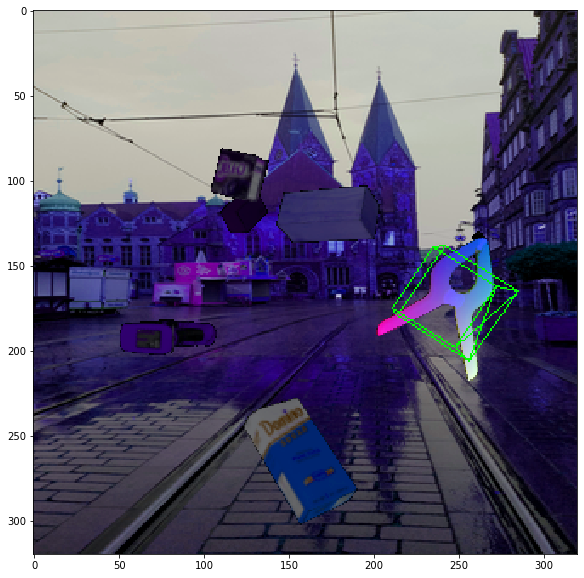

In [70]:
# args, pr_points = pnp.visualize_3D_boxes(image, gt_poses)
fig = plt.figure(figsize=(10, 10))
# y = cv2.add(boxed, pnp.draw_axis(mask, pr_points))
plt.imshow(args['image'])
plt.show()

In [74]:
m = masks[1].astype(np.uint8)
class_id = 20
name = class_names[class_id]
# i = m_id * 3
# mask = gt_masks[:, :, i:i+3].astype(np.uint8)
# name = class_names[class_id]
pnp = PnPSolver(m, int(class_id), name, color=(255, 0, 0), dimension=[.08, .08])
gt_poses = pnp.solve_PnP()
args, pr_points = pnp.visualize_3D_boxes(boxed, gt_poses)

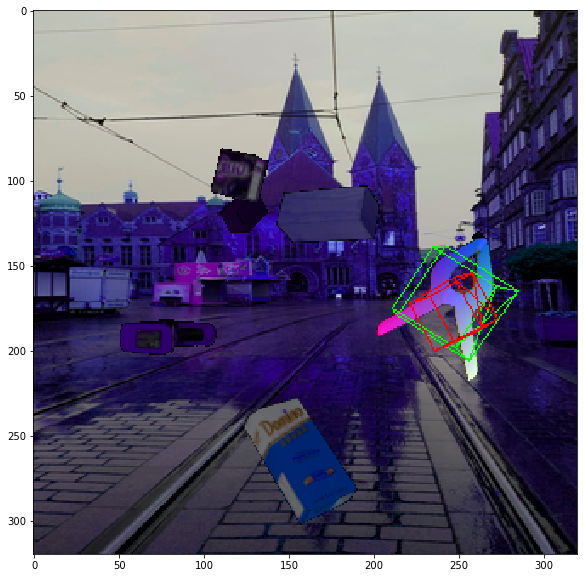

In [75]:
fig = plt.figure(figsize=(10, 10))
# y = cv2.add(boxed, pnp.draw_axis(mask, pr_points))
plt.imshow(args['image'])
plt.show()    

In [ ]:
boxed = gt.copy()
# for m_id, class_id in zip(good_ids, good_class):
m_id = 1
class_id = 13
name = class_names[class_id]
i = m_id * 3
mask = gt_masks[:, :, i:i+3].astype(np.uint8)
# name = class_names[class_id]
pnp = PnPSolver(mask, int(class_id), name, dimension=[.06, .06])
gt_poses = pnp.solve_PnP()
args, pr_points = pnp.visualize_3D_boxes(boxed, gt_poses)

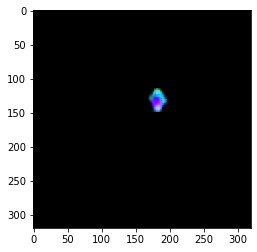

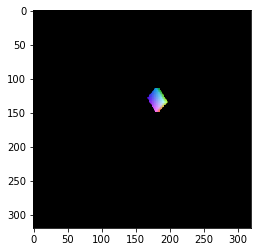

36.84885416666667
0.9924321362078052


In [10]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
# print(ssim(np.ones((320, 320)), m[:, :, 0]))
m_id = 6
m = masks[m_id]
# rm = masks[m_id][:, :, 0]
# gm = masks[m_id][:, :, 1]
# bm = masks[m_id][:, :, 2]
gt_id = 2 * 3
# print(np.unique(m))
plt.imshow(m)
plt.show()
gt = gt_masks[:, :, gt_id:gt_id+3]
# rgt_m = gt_masks[:, :, gt_id]
# ggt_m = gt_masks[:, :, gt_id+1]
# bgt_m = gt_masks[:, :, gt_id+2]
plt.imshow(gt)
plt.show()
# plt.imshow(m)
# plt.show()
# x = np.ones((320, 320, 3)).astype(np.uint8)
# plt.imshow(x)
print(mean_squared_error(gt, m))
print(ssim(gt[:, :, 0], m[:, :, 0]))

In [7]:
gt_m = gt_masks[:, :, 0:3]
m = masks[0]
# plt.imshow(gt_m)
# plt.colorbar()
# plt.show()

# plt.imshow(m)
# plt.colorbar()
# plt.show()
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err
print(mse(m, gt_m))

627.527998046875


In [71]:
print(m.dtype)

uint8


In [75]:
from skimage.metrics import structural_similarity as ssim
print(ssim(np.ones((320, 320)), m[:, :, 0]))

0.01779413795804747


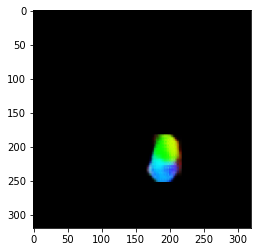

In [36]:
plt.imshow(masks[1])

In [108]:
gt_r_mask = np.array(ground_truth['gt_r_masks'])
gt_g_mask = np.array(ground_truth['gt_g_masks'])
gt_b_mask = np.array(ground_truth['gt_b_masks'])

r_masks = np.array(results['r_masks'])
g_masks = np.array(results['g_masks'])
b_masks = np.array(results['b_masks'])
scores = np.array(results['scores'])

AP, precision, recall, overlaps = utils.compute_ap(gt_box, gt_class_id, gt_r_mask, gt_g_mask, gt_b_mask,
                                                   rois, class_ids, scores, r_masks, g_masks, b_masks)

def plot_precision_recall(AP, precisions, recalls):
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1, figsize=(8, 6))
#     fig = plt.figure(figsize=(8, 6))
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP), fontsize=16)
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    _ = ax.plot(recalls, precisions)

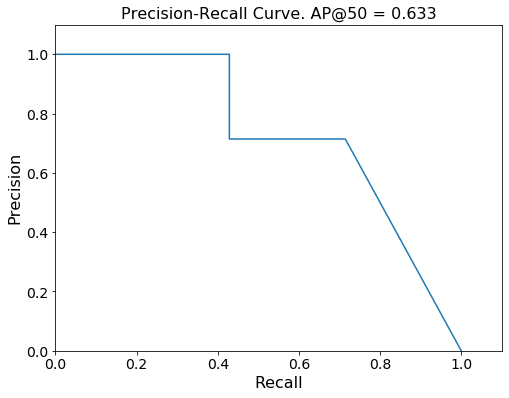

In [109]:
plot_precision_recall(AP, precision, recall)

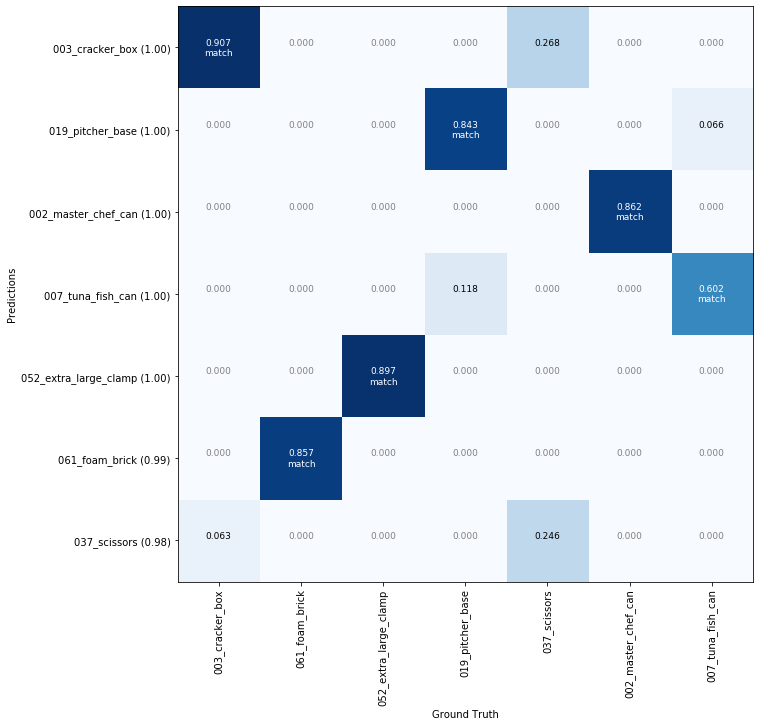

In [39]:
# overlaps = utils.compute_overlaps(gt_box, rois)
visualize.plot_overlaps(gt_class_id, class_ids, results['scores'], overlaps, class_names)

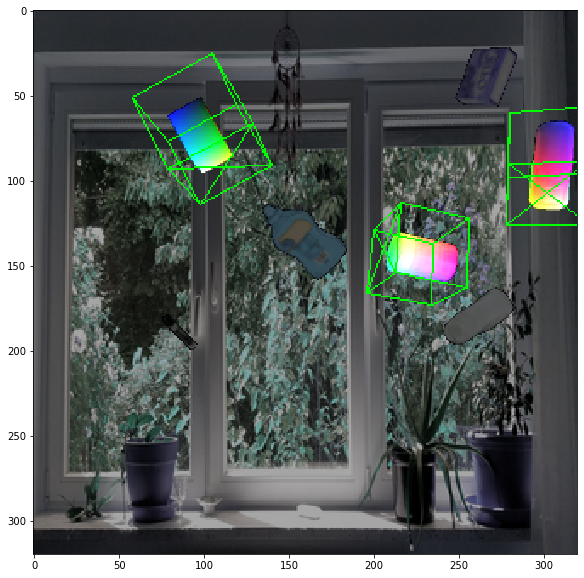

In [84]:
# args, pr_points = pnp.visualize_3D_boxes(image, gt_poses)
fig = plt.figure(figsize=(10, 10))
# y = cv2.add(boxed, pnp.draw_axis(mask, pr_points))
plt.imshow(args['image'])
plt.show()

In [85]:
# boxed = pred.copy()
# m_id = 2
# class_id = 9
for m_id, class_id in zip(g_ids, classes):
    mask = masks[m_id].astype(np.uint8)
    name = class_names[class_id]
    pnp = PnPSolver(mask, int(class_id), name, color=(255, 0, 0), dimension=[.03, .03])
    poses = pnp.solve_PnP()
    #     args['image']
    est_args, pr_points = pnp.visualize_3D_boxes(args['image'], poses)
#     boxed = cv2.add(boxed.astype(np.uint8), poses['image'].astype(np.uint8))
#     if class_id == 15:
#         boxed = cv2.add(boxed, pnp.draw_axis(mask, pr_points))

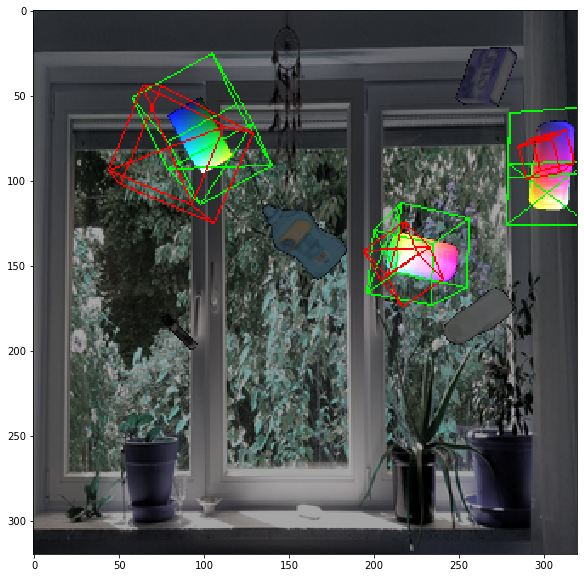

In [86]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(est_args['image'])
# plt.show()
# x = cv2.add(pred, pnp.draw_axis(mask, pr_points))
# plt.imshow()

In [12]:
# fig = plt.figure(figsize=(10, 10))
# plt.imshow(args['image'])
# plt.show()
print(classes)
print(good_ids)
print(g_ids)

[21, 9, 4]
[4, 1, 5]
[0, 2, 6]


In [13]:
add, adi, re, te = evaluation(gt_masks[:, :, 15:18], gt_masks[:, :, 15:18], 4, '005_tomato_soup_can')
print(add, adi, re, te)

(90, 3)
(90, 3)
0.0 0.0 nan 0.0


/home/incendio/Documents/Thesis/MaskRCNN/samples/pose_estimation/pose_evaluation.py:48: RuntimeWarning: invalid value encountered in arccos
  rotational_error = np.rad2deg(np.arccos((np.trace(R_est.dot(R_gt_T)) - 1) / 2))


In [ ]:
# import trimesh
# import os
# MESH_DIR = '/home/incendio/Documents/Thesis/YCBVideo_detector/color_meshes'

# def get_vertex_colors(id_):
#     for name in os.listdir(MESH_DIR):
#         class_id = name.split('_')[0]
#         if int(class_id) == id_:
#             mesh_path = os.path.join(MESH_DIR, name)
#             mesh = trimesh.load(mesh_path)
#             vertex_colors = mesh.visual.vertex_colors[:, :3]
#     return mesh, vertex_colors

# def get_neighbors(image, row, col, window=1):
#     neighbor = image[row - window : row + window + 1, col - window : col + window + 1]
#     color_values = np.reshape(neighbor, (9, 3))
#     return color_values

# mask = gt_masks[:, :, 3:6].astype(np.uint8)
# name = class_names[11]
# mesh, vertex_colors = get_vertex_colors(11)
# rows, cols, channels = np.where(mask > 0)
# rows, cols = np.unique(rows), np.unique(cols)
# print(vertex_colors)
# matching_indices = []
# for index in range(len(rows)):
#     x, y = rows[index], cols[index]
#     R, G, B = mask[x, y, :]
#     r_index = np.where(vertex_colors[:, 0] == R)[0]
#     g_index = np.where(vertex_colors[:, 1] == G)[0]
#     b_index = np.where(vertex_colors[:, 2] == B)[0]
#     all_indices = [r_index, g_index, b_index]
#     matches = np.unique(np.array(list(set(all_indices[0]).intersection(*all_indices))))
#     if len(matches) == 1:
#         print(x, y)
#         to_array = np.unique(np.array(matches))
#         print(matches)
# matching_indices = np.array(matching_indices)
# matching_indices = np.unique(matching_indices)
# print(matching_indices)
#     x_index = np.where((vertex_colors == np.stack([R, G, B])).all())[0]
#     mid_index = (int(len(x_index) / 2), int(len(y_index) / 2))
#     points3d.append(mesh.vertices[x_index[mid_index], :])
# print(np.where(vertex_colors == neighbors))
# image2d = np.array(image2d).astype(np.float32) #(N, 2)
# points3d = np.array(points3d).astype(np.float32) #(N, 3)

(320, 320, 7)


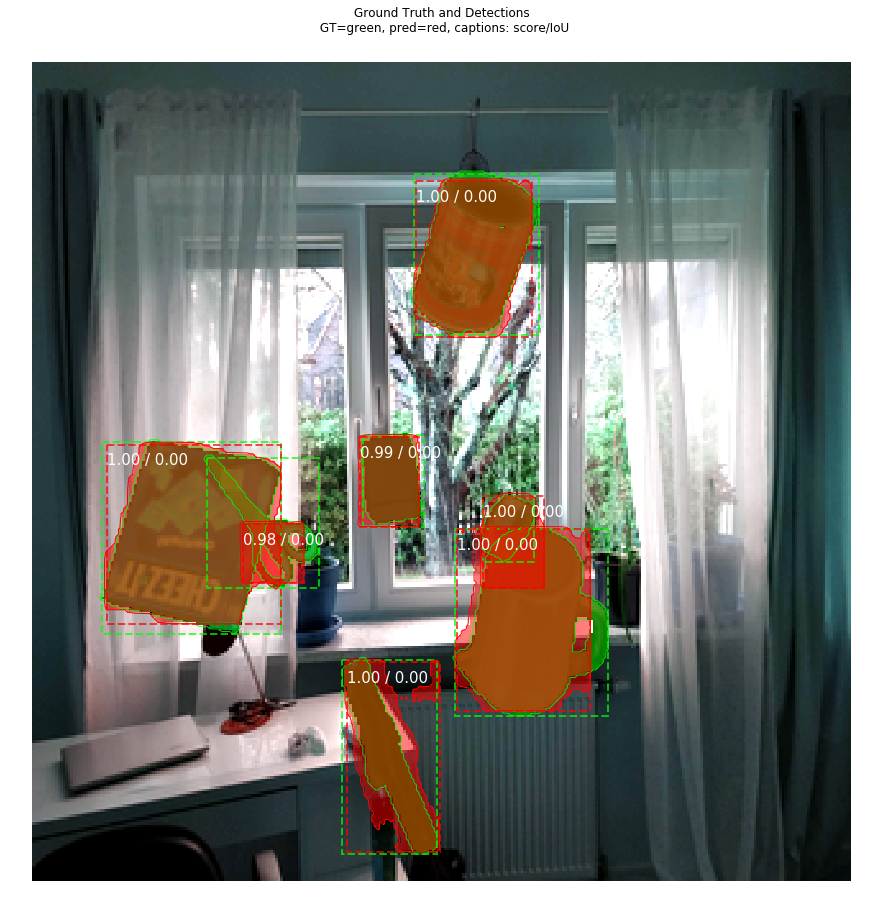

In [9]:
gt_r_masks = []
for i in range(0, 21, 3):
    gt_r_masks.append(gt_masks[:, :, i])
gt_r_masks = np.stack(gt_r_masks, axis=2)
print(gt_r_masks.shape)

visualize.display_differences(image, gt_box, gt_class_id, gt_r_masks, rois, class_ids, np.array(r['scores']),
                              r_masks, class_names)